In [14]:
# %matplotlib widget

import os
import pandas as pd
import numpy as np
import librosa
from librosa import display
import matplotlib.pyplot as plt
import seaborn as sns
import wave
import contextlib

# 1. Preprocessing


In [3]:
ravdess_data = "data/RAVDESS/Speech/"

In [4]:
def extract_labels(file_name):
    parts = file_name.split('-')
    emotion = int(parts[2])  # Emotion is the third part
    return emotion

def label_to_emotion(label):
    if label == 1:
        return "neutral"
    elif label == 2:
        return "calm"
    elif label == 3:
        return "happy"
    elif label == 4:
        return "sad"
    elif label == 5:
        return "angry"
    elif label == 6:
        return "fearful"
    elif label == 7:
        return "disgust"
    elif label == 8:
        return "surprised"
    else:
        return "unknown"

def create_dataframe(directory):
    data = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                label = extract_labels(file)
                emotion = label_to_emotion(label)
                data.append({"FilePath": file_path, "Emotion": emotion, "Label": label})
    df = pd.DataFrame(data)
    return df

In [5]:
dataframe = create_dataframe(ravdess_data)

In [6]:
dataframe.head()

,FilePath,Emotion,Label
0,data/RAVDESS/Speech/Actor_16/03-01-05-01-02-01...,angry,5
1,data/RAVDESS/Speech/Actor_16/03-01-06-01-02-02...,fearful,6
2,data/RAVDESS/Speech/Actor_16/03-01-06-02-01-02...,fearful,6
3,data/RAVDESS/Speech/Actor_16/03-01-05-02-01-01...,angry,5
4,data/RAVDESS/Speech/Actor_16/03-01-07-01-01-01...,disgust,7


In [7]:
print(dataframe.Emotion.value_counts())


Emotion
angry        192
fearful      192
disgust      192
sad          192
surprised    192
happy        192
calm         192
neutral       96
Name: count, dtype: int64


# 2. Data Visualisation and Exploration

In [8]:
dataframe.count()

FilePath    1440
Emotion     1440
Label       1440
dtype: int64

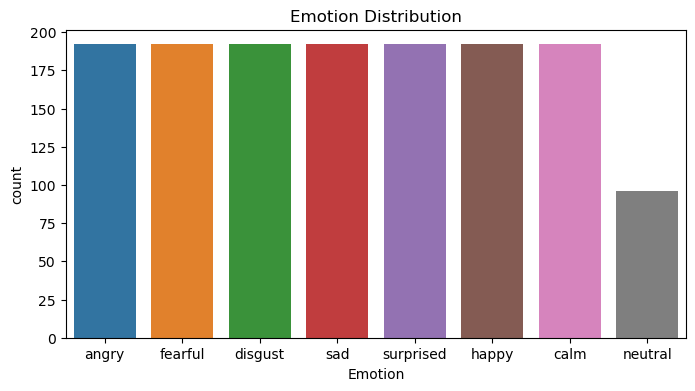

In [9]:
plt.figure(figsize=(8, 4))
sns.countplot(data=dataframe, x="Emotion")
plt.title("Emotion Distribution")
plt.show()

**Check the sampling rate of one random file to make sure it is the same as the one mentioned on the database website.**

In [10]:
sampling_rate = 0
with contextlib.closing(wave.open(dataframe.FilePath[6], 'r')) as wav_file:
    sampling_rate = wav_file.getframerate()
    print(f"Sampling rate: {sampling_rate} Hz")

Sampling rate: 48000 Hz


In [11]:
def load_audio(file_path):
    audio, _ = librosa.load(file_path, sr=sampling_rate)
    return audio

In [12]:
def plot_audio(audio):
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(audio, sr=sampling_rate)
    plt.grid()
    plt.show()

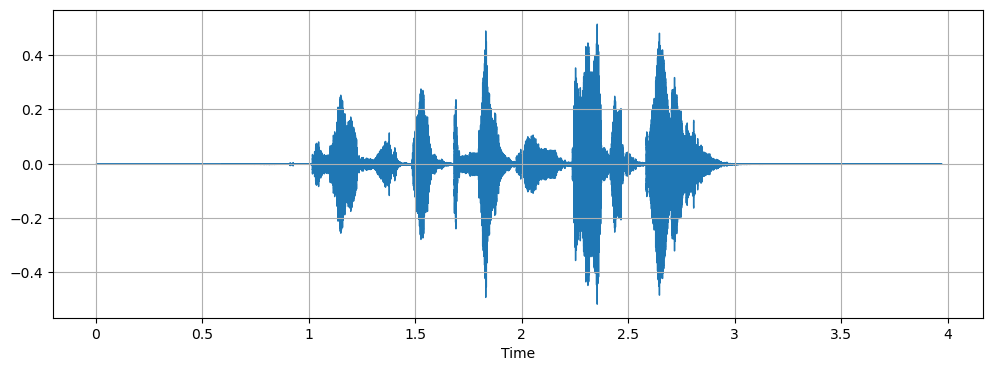

In [13]:
test_audio = load_audio(dataframe.FilePath[3])
plot_audio(test_audio)



# 3. Feature Extraction

### 3.1 Mel-Frequency Cepstral Coefficients (MFCCs)

In [46]:
def extract_mfcc(audio_path, sr=48000, n_mfcc=40):
    audio = load_audio(audio_path)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc.T, axis=0) 

In [47]:
mfcc = extract_mfcc(dataframe.FilePath[3])


In [48]:
mfcc.shape

(40,)